In [18]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [19]:
''' Data Generation '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df

In [20]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [45]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        #if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            #print("Converged after {} iterations".format(_+1))
        #break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [46]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066, 0.311994179861267, 0.36355822375285285, 0.43507121152060635, 0.5060731823429294, 0.5029854374703078, 0.5500666110834043, 0.562685546061902, 0.6098736702765675, 0.6248122700642595, 0.6991900941226588, 0.7199196246566126, 0.7813701143036007, 0.8141978403778407, 0.7895902006715197, 0.7986588808816872, 0.8099275074328214, 0.8211492956356308, 0.8464005828056629, 0.7758277993110598, 0.7576682297371593, 0.7744382810142614, 0.7679157421097678, 0.7566154189216541, 0.7330094787949377, 0.7426839292277004, 0.7464370283678019, 0.7115645706896387, 0.7947529147264347, 0.8099998124566741, 0.8017120123881804, 0.8227809764099893, 0.8456302595031286, 0.8597379798446179, 0.8762384870094257, 0.8673388334313243, 0.8842528857182284, 0.8981406794732238, 0.9143101070060528, 0.9180666987343491, 0.9431446671210302, 0.8965558890544518, 0.8938665702918507, 0.9374946478081118, 0.9804761824839884, 0.938445259658828, 0.8820002536210136, 0.8651123086747814, 0.

In [44]:
def ols_gls_estimationM3(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    
    beta_matrix_OLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_OLS = np.zeros((M, 4)) 
    beta_matrix_GLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_GLS = np.zeros((M, 4)) # Empty matrix to store RMSE values

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y_new = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls_hat = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls_hat = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls_hat = np.concatenate((beta_gls_hat, [theta_gls_hat[0, 0]]))

        beta_matrix_OLS[i, :] = beta_hat 
        beta_matrix_GLS[i, :] = beta_gls_hat  # Store beta parameters in the matrix

        actuals = np.array([0.2, 0.5, 0.3, 0.9])   # True parameters alpha, beta, gamma
        biases_OLS = actuals - np.array(beta_hat)
        mse_OLS = np.mean(np.square(biases_OLS))  # Calculate MSE
        rmse_OLS = np.sqrt(mse_OLS)  # Calculate RMSE
        rmse_matrix_OLS[i, :] = rmse_OLS  # Store RMSE values in the matrix

        biases_GLS = actuals - np.array(beta_gls_hat)
        mse_GLS = np.mean(np.square(biases_GLS))  # Calculate MSE
        rmse_GLS = np.sqrt(mse_GLS)  # Calculate RMSE
        rmse_matrix_GLS[i, :] = rmse_GLS  # Store RMSE values in the matrix

    print("Beta Matrix OLS:")
    print(beta_matrix_OLS)
    print("\nRMSE Matrix OLS:")
    print(rmse_matrix_OLS)
    print("\nMean of Betas OLS:")
    print(np.mean(beta_matrix_OLS, axis=0))
    print("\nMean of RMSE OLS:")
    print(np.mean(rmse_matrix_OLS))
    print("Beta Matrix GLS:")
    print(beta_matrix_GLS)
    print("\nRMSE Matrix GLS:")
    print(rmse_matrix_GLS)
    print("\nMean of Betas GLS:")
    print(np.mean(beta_matrix_GLS, axis=0))
    print("\nMean of RMSE GLS:")
    print(np.mean(rmse_matrix_GLS))


    return beta_matrix_OLS, beta_matrix_GLS

initial_params = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
result_matrix_OLS = ols_gls_estimationM3(df, 1000, initial_params)

Beta Matrix OLS:
[[0.30024144 0.57913542 0.29058151 1.        ]
 [0.25885643 0.60083653 0.25888818 1.        ]
 [0.26326216 0.59096479 0.27068079 1.        ]
 ...
 [0.27760337 0.58945906 0.26001852 1.        ]
 [0.26201581 0.58508614 0.30849159 1.        ]
 [0.31135261 0.59121777 0.27969208 1.        ]]

RMSE Matrix OLS:
[[0.08123957 0.08123957 0.08123957 0.08123957]
 [0.07956486 0.07956486 0.07956486 0.07956486]
 [0.07605312 0.07605312 0.07605312 0.07605312]
 ...
 [0.08003706 0.08003706 0.08003706 0.08003706]
 [0.07272847 0.07272847 0.07272847 0.07272847]
 [0.08822202 0.08822202 0.08822202 0.08822202]]

Mean of Betas OLS:
[0.27642662 0.58131785 0.27483412 1.        ]

Mean of RMSE OLS:
0.07726551136660641
Beta Matrix GLS:
[[-0.26654431  1.55119219 -0.19879873  1.        ]
 [ 0.49585042  0.2743906   0.23169668  1.        ]
 [-0.75728599  1.81054934 -2.01206005  1.        ]
 ...
 [ 0.30352469  0.58015228  0.1764175   1.        ]
 [ 0.31497317  0.51210647  0.35359935  1.        ]
 [ 0.61

In [23]:
def ols_gls_estimationM2(df, M, initial_params, quantiles):
    df = df.astype('float64')  # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T)  # Generate new errors for each iteration

        y_updated = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(i + 1))

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)

    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta

    for p in quantiles:
        beta_quantile_hat_ols = np.percentile(ols_beta_hat, p)
        beta_quantile_hat_gls = np.percentile(gls_beta_hat, p)
        print(f"Quantile {p}% - OLS beta_hat: {beta_quantile_hat_ols:.4f}, GLS beta_hat: {beta_quantile_hat_gls:.4f}")

    biases_ols = actuals - np.array(beta_hat)
    mse_ols = np.mean(np.square(biases_ols))
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")

    biases_gls = actuals - np.array(beta_gls)
    mse_gls = np.mean(np.square(biases_gls))
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [24]:
M=10
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
quantiles = 10, 50, 90
ols_gls_estimationM2(df, M, initial_params, quantiles)

Parameter estimates:
OLS alpha_hat:  [1.7833716974527296, 1.4088766830827957, 1.4655690042313896, 1.1042440858231302, 1.0679218233506205, 1.36295944064634, 1.405130309471074, 1.5215475621432446, 1.5337641457839915, 0.8666358121330919]
OLS beta_hat:  [0.14857335407882866, 0.25100062415121516, 0.2670301601963011, 0.5016133654996554, 0.426619964937604, 0.3058367465463194, 0.33441652482875744, 0.3658125441153518, 0.217869910953303, 0.6076624415690931]
OLS gamma_hat:  [0.03964091305985207, 0.14406979950694065, 0.21549040729348956, 0.6257804596523473, 0.2864367568724825, 0.019868883004653504, 0.08473657198271445, -0.08867608699963803, 0.17017448851119782, 0.1906831341663363]
OLS theta_hat:  [1.0, 1.0, 0.9999999999999997, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0]
GLS alpha_hat:  [-1.153211413821774, 1.9116792432982723, 3.7187865775363598, 1.0721378633845506, 1.07978973007503, 1.4719173648177473, 1.574293085039603, 2.1353596728156115, 4.561164086370933, 1.

In [25]:
M=10
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
quantiles = 10, 50, 90
ols_gls_estimationM2(df, M, initial_params, quantiles)

Parameter estimates:
OLS alpha_hat:  [1.7833716974527296, 1.4088766830827957, 1.4655690042313896, 1.1042440858231302, 1.0679218233506205, 1.36295944064634, 1.405130309471074, 1.5215475621432446, 1.5337641457839915, 0.8666358121330919]
OLS beta_hat:  [0.14857335407882866, 0.25100062415121516, 0.2670301601963011, 0.5016133654996554, 0.426619964937604, 0.3058367465463194, 0.33441652482875744, 0.3658125441153518, 0.217869910953303, 0.6076624415690931]
OLS gamma_hat:  [0.03964091305985207, 0.14406979950694065, 0.21549040729348956, 0.6257804596523473, 0.2864367568724825, 0.019868883004653504, 0.08473657198271445, -0.08867608699963803, 0.17017448851119782, 0.1906831341663363]
OLS theta_hat:  [1.0, 1.0, 0.9999999999999997, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0]
GLS alpha_hat:  [-1.153211413821774, 1.9116792432982723, 3.7187865775363598, 1.0721378633845506, 1.07978973007503, 1.4719173648177473, 1.574293085039603, 2.1353596728156115, 4.561164086370933, 1.

In [26]:
def ols_gls_estimationM3(df, M, initial_params, quantiles):
    df = df.astype('float64')  # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    beta_hat_matrix = []
    rmse_beta_hat_matrix = []
    beta_gls_matrix = []
    rmse_beta_gls_matrix = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T)  # Generate new errors for each iteration

        y_update = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_update, 1)
        y_lag[0] = 0

        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        beta_hat_matrix.append(beta_hat)
        beta_gls_matrix.append(beta_gls)

        actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta

        biases_ols = actuals - np.array(beta_hat)
        mse_ols = np.mean(np.square(biases_ols))
        rmse_ols = np.sqrt(mse_ols)
        rmse_beta_hat_matrix.append(rmse_ols)

        biases_gls = actuals - np.array(beta_gls)
        mse_gls = np.mean(np.square(biases_gls))
        rmse_gls = np.sqrt(mse_gls)
        rmse_beta_gls_matrix.append(rmse_gls)

    beta_hat_matrix = np.array(beta_hat_matrix)
    rmse_beta_hat_matrix = np.array(rmse_beta_hat_matrix)
    beta_gls_matrix = np.array(beta_gls_matrix)
    rmse_beta_gls_matrix = np.array(rmse_beta_gls_matrix)

    print("beta_hat_matrix:")
    print(beta_hat_matrix)
    print("mean of beta_hat_matrix:")
    print(np.mean(beta_hat_matrix, axis=0))
    print("RMSE_beta_hat matrix:")
    print(rmse_beta_hat_matrix)
    print("mean of RMSE_beta_hat matrix:")
    print(np.mean(rmse_beta_hat_matrix))
    print("beta_gls_matrix:")
    print(beta_gls_matrix)
    print("mean of beta_gls_matrix:")
    print(np.mean(beta_gls_matrix, axis=0))
    print("RMSE_beta_gls matrix:")
    print(rmse_beta_gls_matrix)
    print("mean of RMSE_beta_gls matrix:")
    print(np.mean(rmse_beta_gls_matrix))


In [27]:
M=10
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
quantiles = 10, 50, 90
ols_gls_estimationM3(df, M, initial_params, quantiles)

beta_hat_matrix:
[[ 1.7833717   0.14857335  0.03964091  1.        ]
 [ 1.40887668  0.25100062  0.1440698   1.        ]
 [ 1.465569    0.26703016  0.21549041  1.        ]
 [ 1.10424409  0.50161337  0.62578046  1.        ]
 [ 1.06792182  0.42661996  0.28643676  1.        ]
 [ 1.36295944  0.30583675  0.01986888  1.        ]
 [ 1.40513031  0.33441652  0.08473657  1.        ]
 [ 1.52154756  0.36581254 -0.08867609  1.        ]
 [ 1.53376415  0.21786991  0.17017449  1.        ]
 [ 0.86663581  0.60766244  0.19068313  1.        ]]
mean of beta_hat_matrix:
[1.35200206 0.34264356 0.16882053 1.        ]
RMSE_beta_hat matrix:
[0.8228538  0.62403881 0.6467383  0.4831648  0.43842242 0.60799825
 0.61969656 0.69382334 0.68654549 0.34566772]
mean of RMSE_beta_hat matrix:
0.5968949483672453
beta_gls_matrix:
[[-1.15321141  2.59101651 -2.39850796  1.        ]
 [ 1.91167924  0.01565418  0.1655765   1.        ]
 [ 3.71878658 -0.88552841 -1.05225056  1.        ]
 [ 1.07213786  0.5196192   0.6431119   1.      

In [28]:
''' mean of beta_hat_matrix:
[1.35200206 0.34264356 0.16882053 1.    ]

mean of beta_gls_matrix:
[ 1.75442639  0.22950466 -0.18889089  1.        ]

mean of beta_hat_matrix:
[0.43087809 0.54458262 0.16100976 1.        ]

mean of beta_gls_matrix:
[  1.2160798   -8.89056854 -65.69186178   1.    ]'''

' mean of beta_hat_matrix:\n[1.35200206 0.34264356 0.16882053 1.    ]\n\nmean of beta_gls_matrix:\n[ 1.75442639  0.22950466 -0.18889089  1.        ]\n\nmean of beta_hat_matrix:\n[0.43087809 0.54458262 0.16100976 1.        ]\n\nmean of beta_gls_matrix:\n[  1.2160798   -8.89056854 -65.69186178   1.    ]'

In [29]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 1000)

    # Plot the regression lines
    #ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    #ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    #ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')
    
    ax.plot(y, quant_reg_1.params[0] + quant_reg_1.params[1]*y_lag + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(y, quant_reg_5.params[0] + quant_reg_5.params[1]*y_lag + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(y, quant_reg_9.params[0] + quant_reg_9.params[1]*y_lag + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')


    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

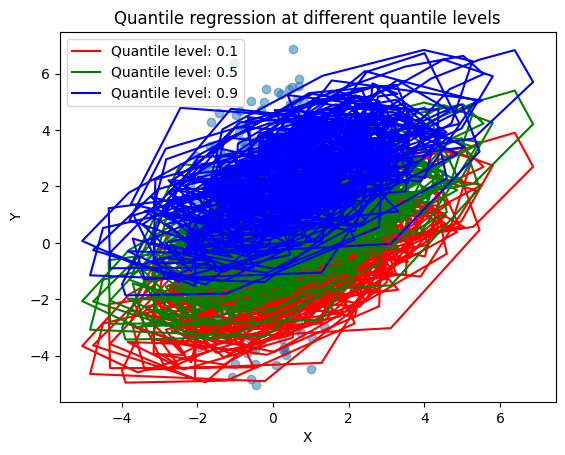

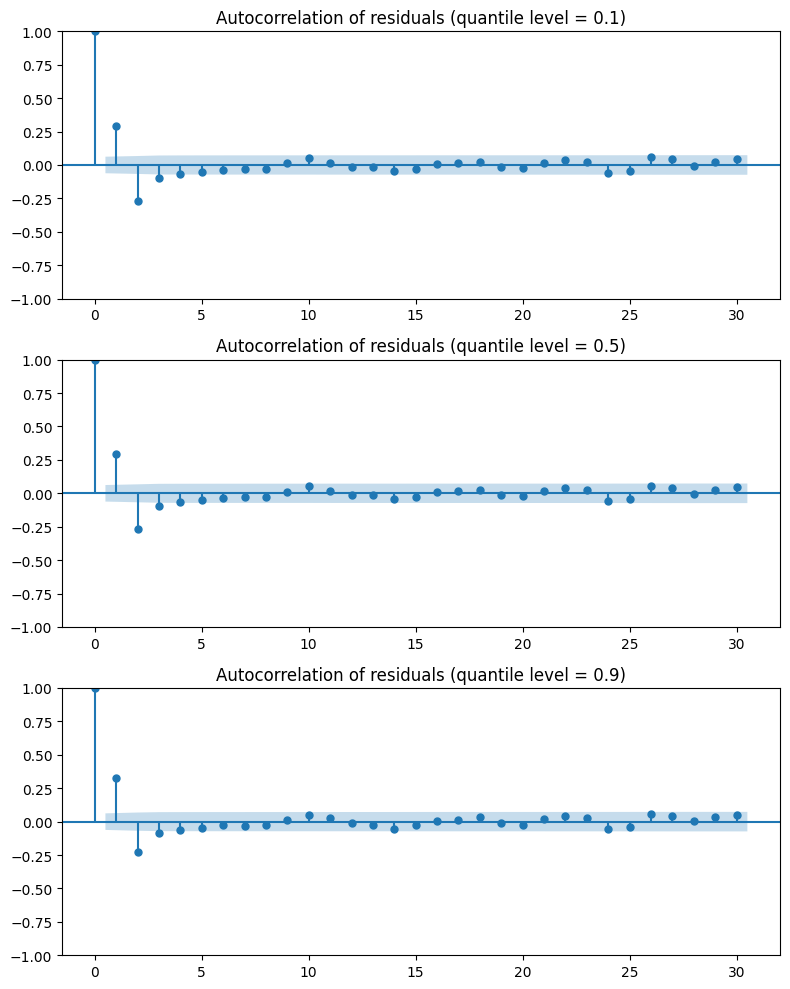

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3451
 Model:                       QuantReg   Bandwidth:                      0.4867
 Method:                 Least Squares   Sparsity:                        7.633
 Date:                Tue, 30 May 2023   No. Observations:                 1000
 Time:                        09:39:30   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.3888      0.078    -17.845      0.000      -1.542      -1.236
 x1             0.7595      0.040     18.828      0.000       0.680       0.839
 x2             0.2507      0.077      3.277      0.001       0.101   

In [30]:
fit_quantile(df)

In [31]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.2, 0.5, 0.3], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix

result_matrix = Laplace_estimation(df, 0.5, 100)


Beta Matrix:
[[0.2        0.5        0.315     ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5125     0.285     ]
 [0.20333333 0.51944444 0.31166667]
 [0.21       0.5        0.3       ]
 [0.19722222 0.51388889 0.31583333]
 [0.20277778 0.50694444 0.30916667]
 [0.19131944 0.4984375  0.3003125 ]
 [0.20666667 0.51666667 0.31      ]
 [0.2        0.5        0.315     ]
 [0.21111111 0.46111111 0.29833333]
 [0.21       0.5        0.3       ]
 [0.19333333 0.48611111 0.31666667]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.525      0.3       ]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.5        0.3       ]
 [0.20185185 0.5462963  0.28333333]
 [0.20279835 0.5468107  0.28148148]
 [0.2        0.5        0.3       ]
 [0.20638889 0.51597222 0.29125   ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.19080247 0.

In [32]:
''' Nelder-Mead 10-good 100-good 1000no

'''


' Nelder-Mead 10-good 100-good 1000no\n\n'

In [33]:
''' Function Laplace_estimation(df, p, M):

// Define log-liklihood    
    
// for i in range(M):
        epsilon = generate_random_laplace_errors(T)  // Generate T random errors from the Laplace distribution
        y = y + epsilon  // Update y with new errors
        
        // Create the design matrix X
        // Compute the covariance matrix S
          
// Set the initial parameter values
    
// Minimize the negative log-likelihood
    
// Print the estimated parameters

'''

' Function Laplace_estimation(df, p, M):\n\n// Define log-liklihood    \n    \n// for i in range(M):\n        epsilon = generate_random_laplace_errors(T)  // Generate T random errors from the Laplace distribution\n        y = y + epsilon  // Update y with new errors\n        \n        // Create the design matrix X\n        // Compute the covariance matrix S\n          \n// Set the initial parameter values\n    \n// Minimize the negative log-likelihood\n    \n// Print the estimated parameters\n\n'

In [34]:
# z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] 
# beta ~ MVN(μ, Σ)                                    - mode m
# σ from Inverted Gamma ~ IΓ(α,β)                  - mode β/α +1


''' EM Algorithm 
def EM_Algorithm(df, M):

1. z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] 
    initialize μ and λ based on the data (y) - mean
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        mode = mu * (np.sqrt(1 + 9 * mu**2 / (4 * lambd**2)) - 3 * mu / (2 * lambd))
    
    # M step: update the parameters
        ?

    return mu, lambd
    ?how does it relate to z?
2. beta ~ MVN(μ, Σ) - mode m                                  
    initialize μ, Σ based on assumptions
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        m
    
    # M step: update the parameters
        ?

    return m
    ?how does it relate to beta?

3. σ from Inverted Gamma ~ IΓ(α,β) - mode β/α +1
    initialize α,β based on assumptions
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        β/α +1
    
    # M step: update the parameters
        ?

    return α,β
    ?how does it relate to sigma?

feed into liklihood 
'''

' EM Algorithm \ndef EM_Algorithm(df, M):\n\n1. z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] \n    initialize μ and λ based on the data (y) - mean\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        mode = mu * (np.sqrt(1 + 9 * mu**2 / (4 * lambd**2)) - 3 * mu / (2 * lambd))\n    \n    # M step: update the parameters\n        ?\n\n    return mu, lambd\n    ?how does it relate to z?\n2. beta ~ MVN(μ, Σ) - mode m                                  \n    initialize μ, Σ based on assumptions\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        m\n    \n    # M step: update the parameters\n        ?\n\n    return m\n    ?how does it relate to beta?\n\n3. σ from Inverted Gamma ~ IΓ(α,β) - mode β/α +1\n    initialize α,β based on assumptions\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        β/α +1\n